In [558]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.read_csv('datasets/players.csv')
df2 = pd.read_csv('datasets/players_teams.csv')
df3 = pd.read_csv('datasets/awards_players.csv')
df4 = pd.read_csv('datasets/teams.csv')
df5 = pd.read_csv('datasets/teams_post.csv')
df6 = pd.read_csv('datasets/coaches.csv')
df7 = pd.read_csv('datasets/series_post.csv')

def corrige_vencedor(teams, series_post):
    # Itera sobre cada rodada ('F', 'CF', 'FR') para ajustar cada fase dos playoffs
    for round_type in ['FR', 'CF', 'F']:
        # Filtra a série específica da rodada
        series_round = series_post[series_post['round'] == round_type]
        
        # Atualiza cada série individualmente
        for _, row in series_round.iterrows():
            year = row['year']
            winner_id = row['tmIDWinner']
            loser_id = row['tmIDLoser']
            
            # Define as colunas que correspondem às rodadas
            if round_type == 'FR':
                round_column = 'firstRound'
            elif round_type == 'CF':
                round_column = 'semis'
            elif round_type == 'F':
                round_column = 'finals'
            
            # Marca o time vencedor como "W" na rodada correspondente
            teams.loc[(teams['year'] == year) & (teams['tmID'] == winner_id), round_column] = 'W'
            
            # Marca o time perdedor como "L" na rodada correspondente
            teams.loc[(teams['year'] == year) & (teams['tmID'] == loser_id), round_column] = 'L'
    
    return teams

teams_file = corrige_vencedor(df4, df7)

players_teams_file = df2.drop(columns=['lgID']) # tirar lgID de tudo porque é tudo igual

players_file = df1[df1['pos'].notna() & (df1['pos'] != '')] # tirar jogadoras com linhas vazias

players_file = players_file.drop(columns=['firstseason', 'lastseason', 'deathDate', 'collegeOther']) # dropar firstseason e lastseason porque têm os valores todos iguais, dropar deathDate porque quase ninguém morreu 
players_file['college'] = players_file['college'].apply(lambda x: 1 if pd.notnull(x) else 0) # substituir college por escolaridade

merged_df = pd.merge(players_teams_file, players_file, left_on='playerID', right_on='bioID', how='left') # merge players_teams e players

merged_df = merged_df.drop(columns=['bioID']) # tirar bioID porque já temos playerID
awards_players_file = df3.drop(columns=['lgID']) # tirar porque é tudo igual
teams_file = df4.drop(columns=['lgID', 'divID', 'tmORB','tmDRB','tmTRB','opptmORB','opptmDRB','opptmTRB','seeded']) # dropar lgID e divID porque é igual em tudo e o resto estava tudo a zero
teams_file['playoff'] = teams_file['playoff'].apply(lambda x: 1 if x=='Y' else 0) # substituir playoff por valores numericos

team_post_file = df5.drop(columns=['lgID']) # tirar lgID de tudo porque é tudo igual
series_post_file = df7.drop(columns=['lgIDWinner', 'lgIDLoser']) # tirar tudo porque é tudo igual
coaches_file = df6.drop(columns=['lgID']) # tirar lgID de tudo porque é tudo igual


awards_grouped = awards_players_file.groupby(['playerID', 'year'])['award'].apply(list).reset_index() # agrupamos numa lista todos os awards de cada jogadora em cada ano
awards_grouped['award'] = awards_grouped['award'].apply(lambda x: x if isinstance(x, list) else []) # se uma jogadora não tem awards -> lista vazia

merged_df = pd.merge(merged_df, awards_grouped, on=['playerID', 'year'], how='left') # merge do dataset que foi merged em cima com o dos awards
merged_df['award'] = merged_df['award'].apply(lambda x: x if isinstance(x, list) else []) # se uma jogadora não tem awards -> lista vazia
merged_df = pd.merge(merged_df, teams_file, on=['tmID','year'], how = 'left') # merge com o teams

merged_df = merged_df.drop(columns=['franchID', 'name']) # dropar franchID porque é igual à sigla da equipa e name porque já temos a sigla

merged_df = pd.merge(merged_df, team_post_file, on=['tmID','year'], how = 'left') # merge com o teams post

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\3116001935.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  winner_summary = winner_counts.groupby(['year', 'round']).size().reset_index(name='winner_count')


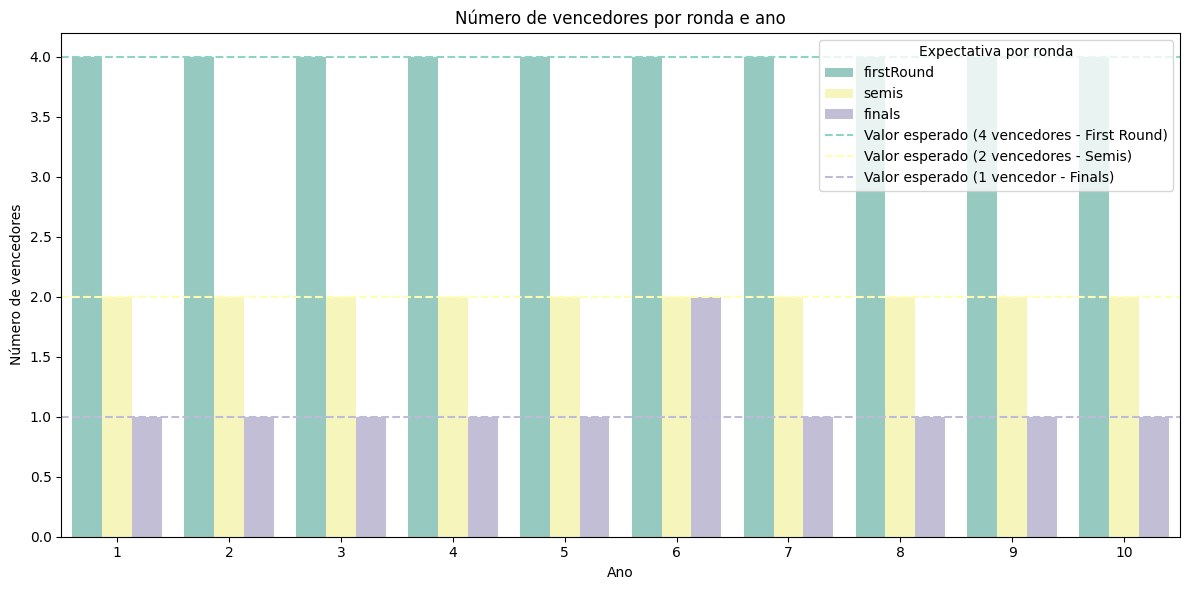

In [559]:
teams = pd.read_csv('datasets/teams.csv')

# Transformar os dados de rodadas em formato longo
winner_counts = teams.melt(
    id_vars=['year', 'tmID'],  # Colunas fixas
    value_vars=['firstRound', 'semis', 'finals'],  # Colunas que serão transformadas
    var_name='round',  # Nome para a coluna das rodadas
    value_name='result'  # Nome para a coluna dos resultados
)

# Filtrar apenas as equipes vencedoras
winner_counts = winner_counts[winner_counts['result'] == 'W']

# Garantir a ordem correta das rodadas
round_order = ['firstRound', 'semis', 'finals']
winner_counts['round'] = pd.Categorical(winner_counts['round'], categories=round_order, ordered=True)

# Contar o número de vencedores por rodada e ano
winner_summary = winner_counts.groupby(['year', 'round']).size().reset_index(name='winner_count')

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Cores para cada rodada
round_colors = {
    'firstRound': sns.color_palette('Set3')[0],
    'semis': sns.color_palette('Set3')[1],
    'finals': sns.color_palette('Set3')[2]
}

# Criar o gráfico de barras
sns.barplot(data=winner_summary, x='year', y='winner_count', hue='round', hue_order=round_order, palette=round_colors)

# Adicionar linhas de valor esperado da mesma cor das barras
plt.axhline(4, color=round_colors['firstRound'], linestyle='--', label='Valor esperado (4 vencedores - First Round)')
plt.axhline(2, color=round_colors['semis'], linestyle='--', label='Valor esperado (2 vencedores - Semis)')
plt.axhline(1, color=round_colors['finals'], linestyle='--', label='Valor esperado (1 vencedor - Finals)')

# Personalizar o gráfico
plt.title('Número de vencedores por ronda e ano')
plt.xlabel('Ano')
plt.ylabel('Número de vencedores')
plt.legend(title='Expectativa por ronda')
plt.tight_layout()

# Exibir o gráfico
#plt.show()

In [560]:
# Calculate min, max, and average player count for each year

player_count_per_team_year = merged_df.groupby(['year', 'tmID'])['playerID'].nunique().reset_index()
player_count_per_team_year.columns = ['Year', 'Team', 'PlayerCount']

# print(player_count_per_team_year)

summary_stats = player_count_per_team_year.groupby('Year')['PlayerCount'].agg(['min', 'max', 'mean']).reset_index()
summary_stats.columns = ['Year', 'MinPlayerCount', 'MaxPlayerCount', 'AvgPlayerCount']

#summary_stats.head(10)

In [561]:
# merge do awards com os coaches

awards_coaches_file = df3.rename(columns={'playerID': 'coachID'})
coach_awards = awards_coaches_file[awards_coaches_file['award'] == 'Coach of the Year']
coach_awards_grouped = coach_awards.groupby(['coachID', 'year'])['award'].apply(list).reset_index()
coaches_file = pd.merge(coaches_file, coach_awards_grouped, on=['coachID', 'year'], how='left')

In [562]:
# Calculate average rebounds by position, excluding secondary positions
avg_rebounds_by_pos_filtered = (
    merged_df.groupby('pos')
    .agg(oRebounds=('oRebounds', 'mean'), dRebounds=('dRebounds', 'mean'))
    .reset_index()
    .query("pos in ['G', 'F', 'C']")
)

avg_rebounds_by_pos_filtered['d_over_o_reb'] = avg_rebounds_by_pos_filtered['dRebounds'] / avg_rebounds_by_pos_filtered['oRebounds']
#avg_rebounds_by_pos_filtered.head(7)

In [563]:
merged_df = merged_df.drop(columns=['rebounds', 'PostRebounds']) # resultado da célula anterior, os rebounds ofensivos/defensivos mudam de acordo com a posição da jogadora, logo decidimos tirar o total de rebounds
merged_df = merged_df.rename(columns={'GP_x': 'GP_player', 'GP_y': 'GP_team'}) # haviam duas colunas com nomes iguais, uma para as jogadoras e outra para as equipas, tinham ficado uma com x e a outra com y então demos rename

In [564]:
# Criar Novas estatisticas -> PER (Player Effiency Rating)

grouped = merged_df.groupby('year').agg({
    'o_pts': 'sum',
    'o_fga': 'sum',
    'o_oreb': 'sum',
    'o_to': 'sum',
    'o_fta': 'sum',
    'o_asts': 'sum',
    'o_fgm' : 'sum',
    'o_ftm': 'sum',
    'o_dreb':'sum',
}).reset_index()

grouped['VOP'] = grouped['o_pts'] / (grouped['o_fga'] - grouped['o_oreb'] + grouped['o_to'] + 0.44 * grouped['o_fta'])
grouped['factor'] = (2 / 3) - (0.5 * (grouped['o_asts'] / grouped['o_fgm'])) / (2 * (grouped['o_fgm'] / grouped['o_ftm']))
grouped['DRB%'] = (grouped['o_dreb'] - grouped['o_oreb']) / grouped['o_dreb']

uPER_df = merged_df.groupby(['playerID', 'year']).agg({
    'minutes': 'sum',     
    'threeMade': 'sum',   
    'assists': 'sum',     
    'fgMade': 'sum',      
    'ftMade': 'sum',      
    'turnovers': 'sum',   
    'fgAttempted': 'sum', 
    'ftAttempted': 'sum', 
    'dRebounds': 'sum',   
    'oRebounds': 'sum',   
    'steals': 'sum',      
    'blocks': 'sum',      
    'PF': 'sum'           
}).reset_index()

uPER_df = uPER_df.merge(grouped[['year', 'VOP', 'factor', 'DRB%']], on='year')

uPER_df['TRB'] = uPER_df['dRebounds'] + uPER_df['oRebounds']

uPER_df['uPER'] = (1 / uPER_df['minutes']) * (
    uPER_df['threeMade'] +
    (2/3) * uPER_df['assists'] +
    (2 - uPER_df['factor'] * (uPER_df['assists'] / uPER_df['fgMade'])) * uPER_df['fgMade'] +
    (uPER_df['ftMade'] * 0.5 * (1 + (1 - (uPER_df['assists'] / uPER_df['fgMade'])) + (2/3) * (uPER_df['assists'] / uPER_df['fgMade']))) -
    uPER_df['VOP'] * uPER_df['turnovers'] -
    uPER_df['VOP'] * uPER_df['DRB%'] * (uPER_df['fgAttempted'] - uPER_df['fgMade']) -
    uPER_df['VOP'] * 0.44 * (0.44 + (0.56 * uPER_df['DRB%'])) * (uPER_df['ftAttempted'] - uPER_df['ftMade']) +
    uPER_df['VOP'] * (1 - uPER_df['DRB%']) * uPER_df['TRB'] +
    uPER_df['VOP'] * uPER_df['DRB%'] * uPER_df['oRebounds'] +
    uPER_df['VOP'] * uPER_df['steals'] +
    uPER_df['VOP'] * uPER_df['DRB%'] * uPER_df['blocks'] -
    uPER_df['PF'] * ((grouped['o_ftm'].mean() / grouped['o_pts'].mean()) - 0.44 * (grouped['o_fta'].mean() / grouped['o_pts'].mean()) * uPER_df['VOP'])
)

lg_uPER = uPER_df.groupby('year')['uPER'].mean().reset_index()
lg_uPER.rename(columns={'uPER': 'lg_uPER'}, inplace=True)

uPER_df = uPER_df.merge(lg_uPER, on='year')

uPER_df['PER'] = uPER_df['uPER'] * (15 / uPER_df['lg_uPER'])


In [565]:
per_to_merge = uPER_df[['playerID', 'year', 'PER']]
merged_df = merged_df.merge(per_to_merge, on=['playerID', 'year'], how='left') # adicionar o PER ao dataset

# novas estatisticas
merged_df['TS%'] = (merged_df['points'] / (2 * (merged_df['fgAttempted'] + 0.44 * merged_df['ftAttempted'])))*100
merged_df['eFG%'] = ((merged_df['fgMade'] + 0.5 * merged_df['threeMade']) / merged_df['fgAttempted'])*100
merged_df['stocks'] = (merged_df['steals'] + merged_df['blocks'])
merged_df['dar'] = ((merged_df['steals'] + merged_df['blocks'] + merged_df['oRebounds'] + merged_df['dRebounds'])/merged_df['minutes'])

# substituir por 0 colunas vazias
merged_df['PER'] = merged_df['PER'].fillna(0)
merged_df['TS%'] = merged_df['TS%'].fillna(0)
merged_df['eFG%'] = merged_df['eFG%'].fillna(0)
merged_df['stocks'] = merged_df['stocks'].fillna(0)
merged_df['dar'] = merged_df['dar'].fillna(0)

#TODO escalar pelos minutos jogados (per, efg stocks e ts pelo tempo. O dar nao pois já tem em conta os minutos jogados)
max_minutes = merged_df['minutes'].max()

if max_minutes != 0:
    # Multiplicando cada valor de 'TS%' pelo fator (min_minutes / max_minutes)
    merged_df['TS%'] = merged_df['TS%'] * (merged_df['minutes'] / max_minutes)
    merged_df['eFG%'] = merged_df['eFG%'] * (merged_df['minutes'] / max_minutes)
    merged_df['PER'] = merged_df['PER'] * (merged_df['minutes'] / max_minutes)
    merged_df['stocks'] = merged_df['stocks'] * (merged_df['minutes'] / max_minutes)

#TODO............................................


#Equipas que não foram aos playoffs
merged_df['W'] = merged_df['W'].fillna(0)
merged_df['L'] = merged_df['L'].fillna(0)

In [566]:
def box_plot_for_each_column(dataset):
    numeric_columns = dataset.select_dtypes(include='number')
    if numeric_columns.empty:
        print("No numeric columns found in the dataset.")
    else:
        numeric_columns.boxplot(figsize=(10, 6))
        plt.title("Boxplot for all numeric columns")
        plt.xticks(rotation=45)  # Rotation in x, if necessary
        plt.show()

def pearson_correlation(dataset, size_x, size_y):
    numeric_columns = dataset.select_dtypes(include='number')
    
    if numeric_columns.empty:
        print("Nenhuma coluna numérica encontrada no dataset.")
    else:
        # Correlation matrix
        correlation_matrix = numeric_columns.corr()

        # View
        plt.figure(figsize=(size_x, size_y))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Pearson-correlation')
        plt.show()

def bar_chart_for_each_column(dataset):
    non_numeric_columns = dataset.select_dtypes(exclude='number')
    if non_numeric_columns.empty:
        print("Any non-numeric columns found in the dataset.")
    else:
        for column in non_numeric_columns.columns:
            value_counts = non_numeric_columns[column].value_counts()
            plt.figure(figsize=(10, 6))
            value_counts.plot(kind='bar')
            plt.title(f"Bar chart for '{column}'")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.tight_layout()  # Adjust layout to prevent overlap
            plt.show()

# Pie-chart for each column
def pie_chart_for_each_column(dataset):
    non_numeric_columns = dataset.select_dtypes(exclude='number')
    
    if non_numeric_columns.empty:
        print("Any non-numeric columns found in the dataset.")
    else:
        for column in non_numeric_columns.columns:
            # Count elements from different categories
            category_counts = dataset[column].value_counts()
            
            # Pie-chart
            plt.figure(figsize=(6, 6))
            category_counts.plot.pie(autopct='%1.1f%%', startangle=140)
            plt.title(f'Distribution of {column}')
            plt.ylabel('')  # Remove o rótulo do eixo Y
            plt.show()


#box_plot_for_each_column(merged_df)
#box_plot_for_each_column(coaches_file)
#box_plot_for_each_column(series_post_file)



In [567]:
#pearson_correlation(merged_df, 100, 80)
#pearson_correlation(coaches_file, 8, 6)
#pearson_correlation(series_post_file, 8, 6)

In [568]:
#bar_chart_for_each_column(merged_df)
#bar_chart_for_each_column(coaches_file)
#bar_chart_for_each_column(series_post_file)

In [569]:
#pie_chart_for_each_column(merged_df)
#pie_chart_for_each_column(coaches_file)
#pie_chart_for_each_column(series_post_file)

In [570]:
# Substituir valores nominais para valores relativos (one-attribute-per-value conversion)
def replaceGameResults(column):
    return column.apply(lambda value: '100' if value == 'W' else '010' if value == 'L' else '001')

# Aplicar a função para cada coluna específica
merged_df['firstRound'] = replaceGameResults(merged_df['firstRound'])
merged_df['semis'] = replaceGameResults(merged_df['semis'])
merged_df['finals'] = replaceGameResults(merged_df['finals'])


In [571]:
# Guardar os datasets numa pasta
if not os.path.exists('cleanDatasets'):
    os.makedirs('cleanDatasets')

merged_df.to_csv('cleanDatasets/players_and_teams.csv', index=False)
coaches_file.to_csv('cleanDatasets/coaches_and_awards.csv', index=False)
series_post_file.to_csv('cleanDatasets/series_post.csv', index=False)

In [572]:
# queriamos construir o dataset em relação às jogadoras então dropamos imensas colunas relativas à equipa

merged_df2 = merged_df.drop(columns=['minutes','threeMade','assists','fgMade','turnovers','fgAttempted','ftAttempted','oRebounds','steals','blocks','PF','o_ftm','o_pts','o_fta','o_pts','o_fga','o_oreb','o_to','o_asts','o_fgm','o_dreb']) # estes atributos já se encontram nas novas colunas criadas
merged_df2 = merged_df2.drop(columns=['GP_player','ftMade','threeAttempted','GP_team'])
merged_df2 = merged_df2.drop(columns=['o_3pm','o_3pa','o_reb','o_pf','o_stl','o_blk','d_fgm','d_fga','d_ftm','d_fta','d_3pm','d_3pa','d_oreb','d_dreb','d_reb','d_asts','d_pf','d_stl','d_to','d_blk','d_pts'])
merged_df2 = merged_df2.drop(columns=['PostGP','PostGS','PostMinutes','PostPoints','PostoRebounds','PostdRebounds','PostAssists','PostSteals','PostBlocks','PostTurnovers','PostPF','PostfgAttempted','PostfgMade','PostftAttempted','PostftMade','PostthreeAttempted','PostthreeMade','PostDQ'])
merged_df2 = merged_df2.drop(columns=['arena'])

# substituir BirthDate por ano em que nasceram
merged_df2['birthDate'] = pd.to_datetime(merged_df['birthDate'], errors='coerce').dt.year
merged_df2 = merged_df2.rename(columns={'birthDate': 'birthYear'})

if not os.path.exists('cleanDatasets'):
    os.makedirs('cleanDatasets')

merged_df2.to_csv('cleanDatasets/advancedstatistics.csv', index=False)

In [573]:
df9 = pd.read_csv('datasetsYear11/players_teams.csv')
df8 = pd.read_csv('datasetsYear11/coaches.csv')
df10 = pd.read_csv('datasetsYear11/teams.csv')

# Agrupar coaches por year e team, transformando em listas
coaches_grouped = df6.groupby(['year', 'tmID'])['coachID'].apply(list).reset_index()

# Fazer o merge com o ficheiro
merged_df2 = merged_df2.merge(coaches_grouped, on=['year', 'tmID'], how='left')

year11 = df9.merge(df8, on=['tmID','year'], how='left')
year11 = year11.merge(df10, on=['tmID','year'], how='left')
finalYear11 = year11[['playerID','year','tmID','confID','coachID']]
finalYear11 = finalYear11.groupby(['playerID', 'year', 'tmID', 'confID'])['coachID'].apply(list).reset_index()

# Adicionar colunas ausentes em finalYear11 com valor 0
expected_columns_merged_df2 = merged_df2.columns
finalYear11 = finalYear11.reindex(columns=expected_columns_merged_df2, fill_value=0)

# Concatenar os datasets
merged_df2 = pd.concat([merged_df2, finalYear11], ignore_index=True)

merged_df2.head(5)

,playerID,year,stint,tmID,GS,points,dRebounds,dq,pos,height,...,min,attend,W,L,PER,TS%,eFG%,stocks,dar,coachID
0,abrossv01w,2,0,MIN,23,343,131,2,F,74.0,...,6475,120607,0.0,0.0,13.226985,33.489853,28.897119,34.964344,0.265957,[aglerbr99w]
1,abrossv01w,3,0,MIN,27,314,101,0,F,74.0,...,6475,139874,0.0,0.0,10.371122,27.904033,26.630747,33.922204,0.245963,"[aglerbr99w, vandehe99w]"
2,abrossv01w,4,0,MIN,25,318,97,0,F,74.0,...,6850,120253,1.0,2.0,11.864571,31.101006,28.037192,35.299838,0.247475,[mcconsu01w]
3,abrossv01w,5,0,MIN,11,146,57,0,F,74.0,...,6850,125097,0.0,2.0,5.445754,17.163170,15.891468,11.980551,0.229437,[mcconsu01w]
4,abrossv01w,6,0,MIN,31,304,78,0,F,74.0,...,6850,113447,0.0,0.0,11.388236,31.062010,28.631263,34.001621,0.207207,[mcconsu01w]


In [574]:
players_stats_prevYear = merged_df2[['playerID','year','PER', 'eFG%', 'TS%','stocks','dRebounds','dar', 'GS']].drop_duplicates().copy() #TODO Acrescentar aqui mais variaveis

#players_stats_prevYear['legacy_points'] = merged_df2['points']
players_stats_prevYear['legacy_points'] = merged_df2['won']
players_stats_prevYear['year'] = players_stats_prevYear['year'] + 1


players_stats_prevYear = players_stats_prevYear.merge(
    merged_df2[['playerID', 'year', 'tmID', 'playoff','coachID','confID']], 
    on=['playerID', 'year'], 
    how='left')

players_stats_prevYear.to_csv('cleanDatasets/players_stats_prevYear.csv', index=False)

In [575]:
#.............................Fazer a media por equipa dos valores mas pegando apenas nos 7 melhores jogadores...............

# Ordenar os jogadores dentro de cada equipe e ano com base no PER (ou outra métrica)
players_stats_prevYear_sorted = players_stats_prevYear.sort_values(by=['tmID', 'year', 'PER'], ascending=[True, True, False])
 
#TODO NAO USAR APENAS 5 jogadores, usar todos da equipa
# Selecionar os 5 melhores jogadores de cada equipe e ano
top_7_players = players_stats_prevYear_sorted.groupby(['tmID', 'year']).head(9)

# Agora, calcular a média das métricas apenas para os melhores jogadores
team_year_stats = top_7_players.groupby(['tmID', 'year', 'playoff','confID']).agg({
    'PER': 'mean',
    'TS%': 'mean',
    'eFG%': 'mean',
    'stocks': 'mean',
    'dRebounds': 'mean',
    'dar': 'mean',
    'GS': 'mean',
    'coachID': 'first',  # Seleciona o primeiro valor da coluna (presumindo que todos sejam iguais para o grupo)
    'legacy_points' : 'mean' #Same here
}).reset_index()

#TODO...........................................................
#playoff_teams_year11 = ["WAS", "NYL", "IND", "ATL", "SEA", "PHO", "SAS", "LAS"]
playoff_teams_year11 = ["WAS", "NYL", "IND", "ATL", "SEA", "PHO", "SAS", "CON"]

team_year_stats.loc[(team_year_stats['year'] == 11) & (team_year_stats['tmID'].isin(playoff_teams_year11)), 'playoff'] = 1
# Salva o novo dataset em um arquivo CSV
team_year_stats.to_csv('cleanDatasets/team_year_stats.csv', index=False)

team_year_stats.head(5)

,tmID,year,playoff,confID,PER,TS%,eFG%,stocks,dRebounds,dar,GS,coachID,legacy_points
0,ATL,9,0.0,EA,7.130778,22.487863,20.972337,15.411669,57.111111,0.221307,10.777778,[meadoma99w],18.777778
1,ATL,10,1.0,EA,8.956513,26.740715,24.489119,22.914641,76.000000,0.257224,17.333333,[meadoma99w],8.444444
2,ATL,11,1.0,EA,10.468933,31.506456,29.149805,31.930308,89.888889,0.233274,19.444444,[meadoma99w],17.666667
3,CHA,2,1.0,EA,8.214271,26.280398,23.619522,20.759139,54.111111,0.189456,13.555556,[donovan99w],14.444444
4,CHA,3,1.0,EA,8.376030,26.572410,23.977519,21.446155,60.000000,0.202011,16.888889,[donovan99w],18.000000


In [576]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#Para depois poder ir buscar as variavies categoricas
team_year_stats_copy = team_year_stats.copy()


# Selecionar as colunas de interesse
features = team_year_stats[['PER', 'TS%', 'eFG%','stocks','dar']] #TODO Acrescentar aqui tambem

# Normalizar os dados usando MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Aplicar o PCA
pca = PCA(n_components=3) #TODO mudar aqui o numero de colunas a selecionar
pca.fit(features_scaled)

# Verificar as cargas (coeficientes) dos componentes principais
components = pca.components_

# Baseado nas cargas, você pode decidir as variáveis mais importantes
# Vamos mostrar a importância de cada variável nas componentes principais

# Calcular a soma das cargas absolutas para cada variável
importance = pd.DataFrame(abs(components), columns=['PER', 'TS%', 'eFG%','stocks','dar'], index=['PC1', 'PC2','PC3']) #TODO mudar aqui as variaveis
#TODO meter tantos PC quanto variaves a selecionar
importance_sum = importance.sum(axis=0)

# Selecionar as duas variáveis mais importantes
most_important_features = importance_sum.sort_values(ascending=False).head(3) #TODO mudar aqui o numero de variaveis

# Exibir apenas os nomes das variáveis mais importantes
important_variable_names = most_important_features.index.tolist()

# Inicializar a lista de componentes a serem removidos
components_to_drop = ['PER', 'TS%', 'eFG%','stocks','dRebounds','dar'] #TODO mudar aqui as variavies (TODOS OS ATRIBUTOS AQUI)
#TODO nao esquecer de aqui adicionar as nao numericas, como os coaches

# Remover as variáveis mais importantes da lista de componentes a serem removidos
components_to_drop = [col for col in components_to_drop if col not in important_variable_names]

team_year_stats=team_year_stats.drop(columns=components_to_drop)

#Adicionar as variaveis categoricas, como os coaches, que nao passaram no processo de PCA
#team_year_stats['coachID'] = team_year_stats_copy['coachID']
team_year_stats['legacy_points'] = team_year_stats_copy['legacy_points']
team_year_stats['GS'] = team_year_stats_copy['GS']
important_variable_names.append('GS')
important_variable_names.append('legacy_points')

# Exibir o resultado
print(important_variable_names)
print(team_year_stats)

['stocks', 'dar', 'eFG%', 'GS', 'legacy_points']
    tmID  year  playoff confID       eFG%     stocks       dar         GS  \
0    ATL     9      0.0     EA  20.972337  15.411669  0.221307  10.777778   
1    ATL    10      1.0     EA  24.489119  22.914641  0.257224  17.333333   
2    ATL    11      1.0     EA  29.149805  31.930308  0.233274  19.444444   
3    CHA     2      1.0     EA  23.619522  20.759139  0.189456  13.555556   
4    CHA     3      1.0     EA  23.977519  21.446155  0.202011  16.888889   
..   ...   ...      ...    ...        ...        ...       ...        ...   
133  WAS     7      1.0     EA  27.033872  24.662075  0.172187  18.500000   
134  WAS     8      0.0     EA  32.354406  34.295876  0.223793  23.222222   
135  WAS     9      0.0     EA  25.818150  26.740501  0.232656  15.444444   
136  WAS    10      1.0     EA  23.814309  21.329372  0.229763  17.222222   
137  WAS    11      1.0     EA  27.300987  30.179092  0.254096  20.875000   

                      coac

In [577]:
# Normalizar os dados 

# Selecionar apenas colunas numéricas
# Lista de colunas a normalizar
columns_to_normalize = ['eFG%', 'stocks','dar','legacy_points', 'GS'] #TODO baseado nas colunas selecionadas do dataset de cima

# Aplicar a normalização apenas nas colunas selecionadas
team_year_stats[columns_to_normalize] = team_year_stats[columns_to_normalize].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Verificar o resultado
print(team_year_stats.head())


  tmID  year  playoff confID      eFG%    stocks       dar        GS  \
0  ATL     9      0.0     EA  0.284330  0.188426  0.592166  0.214559   
1  ATL    10      1.0     EA  0.444426  0.385830  0.845975  0.497126   
2  ATL    11      1.0     EA  0.656596  0.623033  0.676729  0.588123   
3  CHA     2      1.0     EA  0.404839  0.329119  0.367090  0.334291   
4  CHA     3      1.0     EA  0.421136  0.347194  0.455807  0.477969   

        coachID  legacy_points  
0  [meadoma99w]       0.586592  
1  [meadoma99w]       0.067039  
2  [meadoma99w]       0.530726  
3  [donovan99w]       0.368715  
4  [donovan99w]       0.547486  


In [578]:
""" #Passar as colunas que nao sao numericas para numericas
# One-Hot Encoding e é útil para transformar colunas categóricas em representações numéricas binárias.

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Codificando a lista de coaches em colunas binárias
coach_dummies = mlb.fit_transform(team_year_stats['coachID'])

# Adicionando as novas colunas no dataframe original
coach_columns = mlb.classes_
team_year_stats = team_year_stats.join(pd.DataFrame(coach_dummies, columns=coach_columns))

# Adicionando os nomes das novas colunas à lista de variáveis importantes
important_variable_names.extend(coach_columns) """

" #Passar as colunas que nao sao numericas para numericas\n# One-Hot Encoding e é útil para transformar colunas categóricas em representações numéricas binárias.\n\nfrom sklearn.preprocessing import MultiLabelBinarizer\n\nmlb = MultiLabelBinarizer()\n\n# Codificando a lista de coaches em colunas binárias\ncoach_dummies = mlb.fit_transform(team_year_stats['coachID'])\n\n# Adicionando as novas colunas no dataframe original\ncoach_columns = mlb.classes_\nteam_year_stats = team_year_stats.join(pd.DataFrame(coach_dummies, columns=coach_columns))\n\n# Adicionando os nomes das novas colunas à lista de variáveis importantes\nimportant_variable_names.extend(coach_columns) "

In [579]:
#Dividir o dataset para treino, validacao e teste 

dataset_treino = team_year_stats[(team_year_stats['year'] >= 0) & (team_year_stats['year'] <= 10)]
dataset_teste = team_year_stats[team_year_stats['year'] == 11]

In [580]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb

def scale_values(df):
    df_scaled = df.applymap(lambda x: 1 if x > 0.85 else x)
    df_scaled2 = df_scaled.applymap(lambda x: 0 if x < 0.15 else x)
    return df_scaled2

# Features (X) e alvo (y)
X_treino = dataset_treino[important_variable_names] #Antigamente 'PER', 'TS%', 'eFG%'
y_treino = dataset_treino['playoff']

X_teste = dataset_teste[important_variable_names]
y_teste = dataset_teste['playoff']

# Aplicando a transformação para dar mais valores a uns que a outros
X_treino = scale_values(X_treino)
X_teste = scale_values(X_teste)

X_treino.head(20)


C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\699143788.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_scaled = df.applymap(lambda x: 1 if x > 0.85 else x)
C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\699143788.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_scaled2 = df_scaled.applymap(lambda x: 0 if x < 0.15 else x)


,stocks,dar,eFG%,GS,legacy_points
0,0.188426,0.592166,0.284330,0.214559,0.586592
1,0.385830,0.845975,0.444426,0.497126,0.000000
3,0.329119,0.367090,0.404839,0.334291,0.368715
4,0.347194,0.455807,0.421136,0.477969,0.547486
5,0.403835,0.388869,0.518714,0.516284,0.536313
6,0.475337,0.532902,0.437742,0.552802,0.553771
7,0.739150,0.356975,0.836505,0.837165,0.446927
8,0.362237,0.515985,0.237400,0.444444,0.000000
9,0.150818,0.473320,0.194093,0.166667,0.452514
10,0.338599,0.441769,0.268086,0.564176,0.000000


In [581]:
#Criar ficheiros para guardar resultados e avaliar
dataset_resultados = pd.DataFrame({})

dataset_resultados["playoff"] = dataset_teste["playoff"]

#TODO adicionar a team para depois analisar no final
dataset_resultados["tmID"] = dataset_teste["tmID"]

In [582]:
# Inicializar o modelo de regressão linear
modelo = RandomForestRegressor()

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["RandomForestRegressor"] = y_pred_teste

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\597684550.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [583]:
# Inicializar o modelo de regressão linear
modelo = GradientBoostingRegressor()

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["GradientBoostingRegressor"] = y_pred_teste

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\450214780.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [584]:
# Inicializar o modelo de regressão linear
modelo = LinearRegression()

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["LinearRegression"] = y_pred_teste

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\3123343135.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [585]:
#::::::::::::::::::::Este modelo é uma variante da regressão linear que usa regularização L2 para reduzir overfitting.::::::::::::::::

# Inicializar o modelo de Ridge Regression
modelo = Ridge(alpha=1.0)  # alpha controla o nível de regularização

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["Ridge"] = y_pred_teste


C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\1713031855.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [586]:
# Similar ao Ridge, mas utiliza regularização L1. Tende a eliminar variáveis menos importantes, útil para seleção de features.
# Inicializar o modelo de Lasso Regression
modelo = Lasso(alpha=0.1, random_state=42)  # alpha controla a força da regularização

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\977365062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [587]:
# Combina as regularizações L1 (Lasso) e L2 (Ridge).
# Inicializar o modelo de Elastic Net
modelo = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
# `alpha` controla a força total da regularização.
# `l1_ratio` controla a proporção de regularização L1 (Lasso) em relação à L2 (Ridge).

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\151494901.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [588]:
# Inicializar o modelo de MLP
modelo = MLPRegressor(hidden_layer_sizes=(800, 400),  # Camadas ocultas com 100 e 50 neurônios
                      activation='relu',            # Função de ativação
                      solver='adam',                # Otimizador
                      max_iter=500,                 # Número máximo de iterações
                      random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["MLPRegressor_relu"] = y_pred_teste


C:\Users\maxbp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\826227622.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [589]:
# Inicializar o modelo de MLP
modelo = MLPRegressor(hidden_layer_sizes=(100, 50),  # Camadas ocultas com 100 e 50 neurônios
                      activation='tanh',            # Função de ativação
                      solver='adam',                # Otimizador
                      max_iter=500,                 # Número máximo de iterações
                      random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["MLPRegressor_tanh"] = y_pred_teste

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\3422886681.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [590]:
# Inicializar o modelo de MLP
modelo = MLPRegressor(hidden_layer_sizes=(100, 50),  # Camadas ocultas com 100 e 50 neurônios
                      activation='logistic',            # Função de ativação
                      solver='adam',                # Otimizador
                      max_iter=500,                 # Número máximo de iterações
                      random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["MLPRegressor_logistic"] = y_pred_teste

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\989847951.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [591]:
import numpy as np

# Inicializar o modelo sequencial
modelo = Sequential()

# Adicionar camadas
modelo.add(Dense(64, activation='relu', input_shape=(X_treino.shape[1],)))  # Primeira camada oculta
modelo.add(Dense(32, activation='relu'))  # Segunda camada oculta
modelo.add(Dense(1))  # Camada de saída (regressão)

# Compilar o modelo
modelo.compile(optimizer='adam', loss='mse')

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste).flatten()  # Flatten para transformar em 1D

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["Sequential_relu"] = y_pred_teste

Epoch 1/50


C:\Users\maxbp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.5478 - val_loss: 0.4725
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3800 - val_loss: 0.3585
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3122 - val_loss: 0.2860
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2475 - val_loss: 0.2418
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2180 - val_loss: 0.2179
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2131 - val_loss: 0.2124
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2248 - val_loss: 0.2139
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2208 - val_loss: 0.2141
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2256 - val_loss: 0.2128
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2158 - val_loss: 0.2152
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1943 - val_loss: 0.2219
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1977 - val_loss: 0.2350
Epoch 13/50
4/4 ━━━

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\2146543663.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [592]:
import numpy as np

# Inicializar o modelo sequencial
modelo = Sequential()

# Adicionar camadas
modelo.add(Dense(64, activation='tanh', input_shape=(X_treino.shape[1],)))  # Primeira camada oculta
modelo.add(Dense(32, activation='tanh'))  # Segunda camada oculta
modelo.add(Dense(1))  # Camada de saída (regressão)

# Compilar o modelo
modelo.compile(optimizer='adam', loss='mse')

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste).flatten()  # Flatten para transformar em 1D

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["Sequential_tanh"] = y_pred_teste

Epoch 1/50


C:\Users\maxbp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2650 - val_loss: 0.2492
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2460 - val_loss: 0.2623
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2203 - val_loss: 0.2395
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2088 - val_loss: 0.2836
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2409 - val_loss: 0.2692
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2091 - val_loss: 0.2330
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2057 - val_loss: 0.2418
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2275 - val_loss: 0.2313
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2170 - val_loss: 0.2316
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2001 - val_loss: 0.2392
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2133 - val_loss: 0.2317
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2044 - val_loss: 0.2271
Epoch 13/50
4/4 

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\2325067666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [593]:
# Inicializar o modelo de regressão com Extra Trees
modelo = ExtraTreesRegressor(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["ExtraTreesRegressor"] = y_pred_teste

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\4200620747.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [594]:
# Inicializar o modelo ElasticNet
modelo = ElasticNet(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["ElasticNet"] = y_pred_teste


C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\2178884686.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [595]:
# Inicializar o modelo XGBoost Regressor
modelo = xgb.XGBRegressor(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["XGBRegressor"] = y_pred_teste


C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\4215414685.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [596]:
# Inicializar o modelo LightGBM Regressor
modelo = lgb.LGBMRegressor(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["LGBMRegressor"] = y_pred_teste



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 126, number of used features: 5
[LightGBM] [Info] Start training from score 0.571429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\191379248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [597]:
# Inicializar o modelo de regressão com Gradient Boosting
modelo = GradientBoostingRegressor(random_state=42) #TODO porque foi o melhor modelo até agora

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

# Critério de correção
# 1. Quando 'playoff' é 1, 'playoff_previsto' deve ser > 0.5
# 2. Quando 'playoff' é 0, 'playoff_previsto' deve ser <= 0.5

# Criar uma coluna indicando se a previsão está correta
dataset_teste['correto'] = ((dataset_teste['playoff'] == 1) & (dataset_teste['playoff_previsto'] > 0.5)) | \
                           ((dataset_teste['playoff'] == 0) & (dataset_teste['playoff_previsto'] <= 0.5))

# Contar o número de previsões corretas
corretos = dataset_teste['correto'].sum()

# Número total de exemplos
total = len(dataset_teste)

# Exibir o resultado
print(f"Previsões corretas: {corretos} de {total} ({(corretos / total) * 100:.2f}%)")

dataset_resultados["GradientBoostingRegressor"] = y_pred_teste


Previsões corretas: 8 de 12 (66.67%)


C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\2616487240.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste
C:\Users\maxbp\AppData\Local\Temp\ipykernel_26472\2616487240.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['correto'] = ((dataset_teste['playoff'] == 1) & (dataset_teste['playoff_previsto'] > 0.5)) | \


In [598]:
#Para mostrar os resultados obtidos pelos varios modelos
dataset_resultados.head(20)

,playoff,tmID,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,Ridge,MLPRegressor_relu,MLPRegressor_tanh,MLPRegressor_logistic,Sequential_relu,Sequential_tanh,ExtraTreesRegressor,ElasticNet,XGBRegressor,LGBMRegressor
2,1.0,ATL,0.88,0.775521,0.740620,0.727164,0.966151,0.802379,0.685762,0.783768,0.810381,0.74,0.571429,0.979474,0.911868
13,0.0,CHI,0.14,0.359892,0.196110,0.230825,0.483791,0.188222,0.678814,0.141179,0.105498,0.04,0.571429,0.075729,0.270132
24,1.0,CON,0.58,0.737859,0.441378,0.453195,1.282022,0.510145,0.683489,0.556051,0.551604,0.61,0.571429,0.878499,0.458302
51,1.0,IND,0.79,0.823855,0.826264,0.799007,1.479369,0.861123,0.685902,0.752210,0.875342,0.78,0.571429,0.909940,0.819967
61,0.0,LAS,0.85,0.793922,0.730218,0.718469,0.804639,0.787387,0.685404,0.770687,0.789009,0.68,0.571429,0.910552,0.884533
73,0.0,MIN,0.48,0.417061,0.824053,0.815782,0.030703,0.871779,0.686033,0.789021,0.816825,0.63,0.571429,0.316502,0.581105
83,1.0,NYL,0.06,-0.231559,0.359874,0.379743,-0.083225,0.401832,0.681327,0.348835,0.355040,0.10,0.571429,-0.042231,0.285239
95,1.0,PHO,0.73,0.884244,0.660040,0.654003,0.437732,0.724538,0.685054,0.590684,0.667382,0.75,0.571429,0.771770,0.696829
114,1.0,SAS,0.46,0.285054,1.042231,1.004143,-0.690004,1.083038,0.688881,0.913036,1.136364,0.57,0.571429,0.423804,0.428496
124,1.0,SEA,0.76,0.603229,0.840104,0.821915,1.217713,0.898806,0.687831,0.843510,0.952336,0.75,0.571429,0.727626,0.744822


In [599]:
#TODO adicionar as confID para selecionar os 4 melhores de cada liga

#Seleciona os valores para cada equipa da conf
dataset_para_obter_confID = pd.read_csv('cleanDatasets/team_year_stats.csv')
y_unique = dataset_para_obter_confID[['tmID', 'confID']].drop_duplicates()

# Adiciona a confID ao dataset x com base na correspondência com y
dataset_resultados = dataset_resultados.merge(y_unique[['tmID', 'confID']], on='tmID', how='left')

dataset_resultados.head(20)

,playoff,tmID,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,Ridge,MLPRegressor_relu,MLPRegressor_tanh,MLPRegressor_logistic,Sequential_relu,Sequential_tanh,ExtraTreesRegressor,ElasticNet,XGBRegressor,LGBMRegressor,confID
0,1.0,ATL,0.88,0.775521,0.740620,0.727164,0.966151,0.802379,0.685762,0.783768,0.810381,0.74,0.571429,0.979474,0.911868,EA
1,0.0,CHI,0.14,0.359892,0.196110,0.230825,0.483791,0.188222,0.678814,0.141179,0.105498,0.04,0.571429,0.075729,0.270132,EA
2,1.0,CON,0.58,0.737859,0.441378,0.453195,1.282022,0.510145,0.683489,0.556051,0.551604,0.61,0.571429,0.878499,0.458302,EA
3,1.0,IND,0.79,0.823855,0.826264,0.799007,1.479369,0.861123,0.685902,0.752210,0.875342,0.78,0.571429,0.909940,0.819967,EA
4,0.0,LAS,0.85,0.793922,0.730218,0.718469,0.804639,0.787387,0.685404,0.770687,0.789009,0.68,0.571429,0.910552,0.884533,WE
5,0.0,MIN,0.48,0.417061,0.824053,0.815782,0.030703,0.871779,0.686033,0.789021,0.816825,0.63,0.571429,0.316502,0.581105,WE
6,1.0,NYL,0.06,-0.231559,0.359874,0.379743,-0.083225,0.401832,0.681327,0.348835,0.355040,0.10,0.571429,-0.042231,0.285239,EA
7,1.0,PHO,0.73,0.884244,0.660040,0.654003,0.437732,0.724538,0.685054,0.590684,0.667382,0.75,0.571429,0.771770,0.696829,WE
8,1.0,SAS,0.46,0.285054,1.042231,1.004143,-0.690004,1.083038,0.688881,0.913036,1.136364,0.57,0.571429,0.423804,0.428496,WE
9,1.0,SEA,0.76,0.603229,0.840104,0.821915,1.217713,0.898806,0.687831,0.843510,0.952336,0.75,0.571429,0.727626,0.744822,WE


In [600]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Criando o DataFrame
df = pd.DataFrame(dataset_resultados)

# Inicializar lista para armazenar os resultados
resultados = []

# Número de melhores previsões para considerar como 1 por conferência
top_n_conferencia = 4

# Loop sobre cada coluna do modelo (excluindo a coluna 'playoff')
for modelo in df.columns[2:-1]:
    # Cálculo de métricas de regressão
    mse = mean_squared_error(df["playoff"], df[modelo])
    mae = mean_absolute_error(df["playoff"], df[modelo])
    r2 = abs(r2_score(df["playoff"], df[modelo]))
    
    # Binarização dos valores (top 4 melhores de cada conferência como 1)
    y_true = (df["playoff"] >= 0.5).astype(int)
    y_pred = pd.Series(0, index=df.index)  # Inicializa com 0 para todos
    
    # Separa os dados por conferência
    conferencia_1 = df[df["confID"] == "WE"]
    conferencia_2 = df[df["confID"] == "EA"]
    
    # Obtém os índices dos top 4 de cada conferência
    top_indices_1 = conferencia_1[modelo].nlargest(top_n_conferencia).index
    top_indices_2 = conferencia_2[modelo].nlargest(top_n_conferencia).index
    
    # Define 1 para os top 4 de cada conferência
    y_pred.loc[top_indices_1] = 1
    y_pred.loc[top_indices_2] = 1
    
    # Cálculo de métricas de classificação
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Adicionar os resultados à lista
    resultados.append({
        "Modelo": modelo,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy
    })

# Converter os resultados em um DataFrame
resultados_4_melhores = pd.DataFrame(resultados)

# Exibir os resultados
resultados_4_melhores.head(10)



,Modelo,MSE,MAE,R²,Precision,Recall,Accuracy
0,RandomForestRegressor,0.230933,0.400000,0.039200,0.750,0.750,0.666667
1,GradientBoostingRegressor,0.297401,0.438368,0.338306,0.750,0.750,0.666667
2,LinearRegression,0.194235,0.363857,0.125942,0.750,0.750,0.666667
3,Ridge,0.192882,0.367809,0.132032,0.750,0.750,0.666667
4,MLPRegressor_relu,0.530633,0.558698,1.387848,0.625,0.625,0.500000
5,MLPRegressor_tanh,0.187378,0.342432,0.156798,0.750,0.750,0.666667
6,MLPRegressor_logistic,0.221123,0.437166,0.004948,0.750,0.750,0.666667
7,Sequential_relu,0.186944,0.354864,0.158752,0.750,0.750,0.666667
8,Sequential_tanh,0.183776,0.335501,0.173007,0.750,0.750,0.666667
9,ExtraTreesRegressor,0.202817,0.373333,0.087325,0.750,0.750,0.666667


In [601]:
'''
# Criar o DataFrame com os dados necessários
resultados_4_melhores = pd.DataFrame({
    "playoff": dataset_resultados["playoff"],
    "prev_regression": dataset_resultados["GradientBoostingRegressor"]
})

# Ordenar o DataFrame pela coluna 'prev_regression' de forma decrescente
resultados_4_melhores_sorted = resultados_4_melhores.sort_values('prev_regression', ascending=False)

# Criar a nova coluna 'top_8' que marca as 8 melhores entradas como 1 e as outras como 0
resultados_4_melhores_sorted['top_8'] = 0

# Marcar as 8 melhores previsões como 1
resultados_4_melhores_sorted.iloc[:8, resultados_4_melhores_sorted.columns.get_loc('top_8')] = 1

# Reordenar o DataFrame para a ordem original
resultados_4_melhores_final = resultados_4_melhores_sorted.sort_index()

# Assumindo que 'top_8' seja a variável de verdade (y_true)
y_true = resultados_4_melhores_final['top_8']

# Encontrar o limiar de corte para as 8 melhores entradas em 'prev_regression'
threshold = resultados_4_melhores_final['prev_regression'].nlargest(8).min()

# Converter as previsões de 'prev_regression' em binário, onde 1 significa estar entre as 8 melhores previsões
y_pred = (resultados_4_melhores_final['prev_regression'] >= threshold).astype(int)

# Para mudar o nome de uma coluna, basta usar o método rename
resultados_4_melhores_final = resultados_4_melhores_final.rename(columns={'top_8': 'prev_class'})

#......................Desenhar a curva.................................
from sklearn.metrics import precision_recall_curve

# Supondo que 'resultados_4_melhores_final' tenha as colunas 'playoff' e 'prev_class'
y_true = resultados_4_melhores_final['playoff']  # Rótulos reais
y_scores = resultados_4_melhores_final['prev_class']  # Probabilidades ou escores de previsão

# Calcular a curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Plotar a curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall, classifica as 8 melhores equipas com 1 e as outras com 0')
plt.grid(True)
plt.legend()
plt.show()

resultados_4_melhores_final.head(20)
'''




'\n# Criar o DataFrame com os dados necessários\nresultados_4_melhores = pd.DataFrame({\n    "playoff": dataset_resultados["playoff"],\n    "prev_regression": dataset_resultados["GradientBoostingRegressor"]\n})\n\n# Ordenar o DataFrame pela coluna \'prev_regression\' de forma decrescente\nresultados_4_melhores_sorted = resultados_4_melhores.sort_values(\'prev_regression\', ascending=False)\n\n# Criar a nova coluna \'top_8\' que marca as 8 melhores entradas como 1 e as outras como 0\nresultados_4_melhores_sorted[\'top_8\'] = 0\n\n# Marcar as 8 melhores previsões como 1\nresultados_4_melhores_sorted.iloc[:8, resultados_4_melhores_sorted.columns.get_loc(\'top_8\')] = 1\n\n# Reordenar o DataFrame para a ordem original\nresultados_4_melhores_final = resultados_4_melhores_sorted.sort_index()\n\n# Assumindo que \'top_8\' seja a variável de verdade (y_true)\ny_true = resultados_4_melhores_final[\'top_8\']\n\n# Encontrar o limiar de corte para as 8 melhores entradas em \'prev_regression\'\nthre

In [602]:
#Com os 8 melhores
# Resultados considerando que ficam a 1 os 8 melhores

from sklearn.metrics import precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Criando o DataFrame
df = pd.DataFrame(dataset_resultados)

# Inicializar lista para armazenar os resultados
resultados = []

# Número de melhores previsões para considerar como 1
top_n = 8

# Loop sobre cada coluna do modelo (excluindo a coluna 'playoff')
for modelo in df.columns[2:-1]:
    # Cálculo de métricas de regressão
    mse = mean_squared_error(df["playoff"], df[modelo])
    mae = mean_absolute_error(df["playoff"], df[modelo])
    r2 = abs(r2_score(df["playoff"], df[modelo]))
    
    # Binarização dos valores (top 8 melhores como 1)
    y_true = (df["playoff"] >= 0.5).astype(int)
    y_pred = pd.Series(0, index=df.index)  # Inicializa com 0 para todos
    top_indices = df[modelo].nlargest(top_n).index  # Obtém índices dos top 8 valores
    y_pred.loc[top_indices] = 1  # Define 1 para os top 8 valores
    
    # Cálculo de métricas de classificação
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Adicionar os resultados à lista
    resultados.append({
        "Modelo": modelo,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy
    })

# Converter os resultados em um DataFrame
resultados_8_melhores = pd.DataFrame(resultados)

# Exibir os resultados
resultados_8_melhores.head(10)


,Modelo,MSE,MAE,R²,Precision,Recall,Accuracy
0,RandomForestRegressor,0.230933,0.400000,0.039200,0.75,0.75,0.666667
1,GradientBoostingRegressor,0.297401,0.438368,0.338306,0.75,0.75,0.666667
2,LinearRegression,0.194235,0.363857,0.125942,0.75,0.75,0.666667
3,Ridge,0.192882,0.367809,0.132032,0.75,0.75,0.666667
4,MLPRegressor_relu,0.530633,0.558698,1.387848,0.75,0.75,0.666667
5,MLPRegressor_tanh,0.187378,0.342432,0.156798,0.75,0.75,0.666667
6,MLPRegressor_logistic,0.221123,0.437166,0.004948,0.75,0.75,0.666667
7,Sequential_relu,0.186944,0.354864,0.158752,0.75,0.75,0.666667
8,Sequential_tanh,0.183776,0.335501,0.173007,0.75,0.75,0.666667
9,ExtraTreesRegressor,0.202817,0.373333,0.087325,0.75,0.75,0.666667


In [603]:
#TODO Avaliar da forma do stor

# Identificar as colunas dos modelos (exceto playoff, tmID e confID)
model_columns = [
    col for col in dataset_resultados.columns 
    if col not in ['playoff', 'tmID', 'confID'] and not col.startswith(('adj_', 'error_'))
]

# Aplicar a transformação para cada coluna de modelo
for col in model_columns:
    # Calcular o valor ajustado (adj. pred)
    dataset_resultados[f'adj_{col}'] = 8 * dataset_resultados[col] / dataset_resultados[col].sum()
    
    # Normalizar os valores para estarem entre 0 e 1
    min_val = dataset_resultados[f'adj_{col}'].min()
    max_val = dataset_resultados[f'adj_{col}'].max()
    if max_val - min_val != 0:
        dataset_resultados[f'adj_{col}'] = (dataset_resultados[f'adj_{col}'] - min_val) / (max_val - min_val)
    
    # Arredondar os valores para duas casas decimais
    dataset_resultados[f'adj_{col}'] = dataset_resultados[f'adj_{col}'].round(2)
    
    # Ajustar os valores para garantir que a soma seja 8
    total_sum = dataset_resultados[f'adj_{col}'].sum()
    if total_sum != 0:
        adjustment_factor = 8 / total_sum
        dataset_resultados[f'adj_{col}'] = (dataset_resultados[f'adj_{col}'] * adjustment_factor).round(2)
    
    # Garantir que os valores estejam entre 0 e 1 após o ajuste
    dataset_resultados[f'adj_{col}'] = dataset_resultados[f'adj_{col}'].clip(0, 1)
    
    # Calcular o erro absoluto em relação a 'playoff'
    dataset_resultados[f'error_{col}'] = abs(dataset_resultados[f'adj_{col}'] - dataset_resultados['playoff'])

# Identificar as colunas de erro (que começam com 'error_')
error_columns = [col for col in dataset_resultados.columns if col.startswith('error_')]

# Criar um dicionário com os erros finais para cada modelo
final_errors = {
    col.replace('error_', ''): dataset_resultados[col].sum() for col in error_columns
}

# Criar um DataFrame com os resultados finais
error_summary = pd.DataFrame(final_errors.items(), columns=['Model', 'Final Error'])

# Salvar o resultado num CSV
output_columns = dataset_resultados[['tmID', 'adj_ExtraTreesRegressor']]
output_columns = output_columns.rename(columns={'adj_ExtraTreesRegressor': 'Playoff'})
output_columns.to_csv('results4.csv', index=False)

teste = dataset_resultados[['playoff','tmID','adj_ExtraTreesRegressor','error_ExtraTreesRegressor']]

print("Erro total:", teste['error_ExtraTreesRegressor'].sum())
print("Adj total:", teste['adj_ExtraTreesRegressor'].sum())
error_summary.head(15)
#teste.head(20)

Erro total: 3.49
Adj total: 7.970000000000001


,Model,Final Error
0,RandomForestRegressor,3.87
1,GradientBoostingRegressor,4.66
2,LinearRegression,3.90
3,Ridge,3.93
4,MLPRegressor_relu,4.82
5,MLPRegressor_tanh,3.82
6,MLPRegressor_logistic,3.69
7,Sequential_relu,3.73
8,Sequential_tanh,3.68
9,ExtraTreesRegressor,3.49
